# Structural Analysis of NES Regions
This notebook analyzes the structural feature of NES regions, specifically:
- Helical regions
- Exposed regions
It also outputs the results in a format suitable for futher analysis (in protein_prediction/)

In [ ]:
import glob
import os
import sys
import requests
from pathlib import Path
import time
import pandas as pd
from Bio.PDB import PDBParser, DSSP
import ast
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
from scipy.stats import ttest_rel

In [53]:
def download_alphafold_pdbs(uniprot_ids, output_folder="alphafold_pdbs"):
    """
    Download AlphaFold PDB files for a list of UniProt IDs.

    Args:
        uniprot_ids (list): List of UniProt IDs
        output_folder (str): Folder to save the PDB files

    Returns:
        dict: Dictionary mapping UniProt IDs to download status (True for success, False for failure)
    """
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    results = {}

    for uniprot_id in uniprot_ids:
        url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"
        output_path = os.path.join(output_folder, f"{uniprot_id}.pdb")

        try:
            print(f"Downloading {uniprot_id}...")
            response = requests.get(url, timeout=30)

            if response.status_code == 200:
                with open(output_path, 'wb') as f:
                    f.write(response.content)
                print(f"✅ Successfully downloaded {uniprot_id}")
                results[uniprot_id] = True
            else:
                print(f"❌ Failed to download {uniprot_id}: HTTP status {response.status_code}")
                results[uniprot_id] = False

            time.sleep(1)  # polite delay

        except Exception as e:
            print(f"❌ Error downloading {uniprot_id}: {str(e)}")
            results[uniprot_id] = False

    return results

def get_uniprot_ids_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    return df["uniprotID"].dropna().unique().tolist()



In [16]:


def get_ground_truth_ranges(csv_path, uniprot_id):
    """Return NES ranges (e.g., ['34-49']) from the NES CSV."""
    df = pd.read_csv(csv_path)
    
    # Filter the row for the given UniProt ID
    row = df[df['uniprotID'] == uniprot_id]
    
    if row.empty:
        print(f"No entry found for UniProt ID: {uniprot_id}")
        return []
    
    # Extract the start_end_ranges column value as string
    ranges_str = row.iloc[0]['start_end_ranges']
    
    # Convert string representation of list to actual Python list
    try:
        ground_truth_ranges = ast.literal_eval(ranges_str)
    except Exception as e:
        print(f"Error parsing ranges: {e}")
        ground_truth_ranges = []
    
    return ground_truth_ranges


In [23]:
def parse_dssp(pdb_path, dssp_exe="dssp/mkdssp", rsa_thresh=0.25):
    """Return boolean lists of helix and exposed residues from DSSP output."""
    
    helix_codes = {"H", "G", "I"}

    # Parse structure
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("model", pdb_path)
    model = structure[0]

    # Run DSSP
    dssp = DSSP(model, pdb_path, dssp=dssp_exe)

    # Initialize outputs
    is_helix = []
    is_exposed = []

    for key in dssp.keys():
        dssp_data = dssp[key]
        #print(dssp_data)

        ss = dssp_data[2]      # secondary structure (1-letter code)
        #rsa = dssp_data[3]     # relative solvent accessibility (0-1)
        try:
            #print(dssp_data[3])
            rsa = float(dssp_data[3])
        except ValueError:
            rsa = 0.0  # fallback: treat as buried if invalid

        is_helix.append(ss in helix_codes)
        is_exposed.append(rsa >= rsa_thresh)

    return is_helix, is_exposed

In [19]:
def plot_feature_blocks(is_helix, is_exposed, ground_truth_ranges, title="Feature blocks along sequence"):
    """
    Plot blocks showing locations of helix, exposed, both, and ground truth regions.

    Args:
        is_helix (list of bool): Helix presence per residue.
        is_exposed (list of bool): Exposure presence per residue.
        ground_truth_ranges (list of tuples): List of (start, end) residue indices from CSV.
        title (str): Plot title.
    """
    seq_len = len(is_helix)
    x_range = (0, seq_len)

    # Helper to convert bool list into blocks of continuous True regions as (start, length)
    def bool_list_to_blocks(bool_list):
        blocks = []
        start = None
        for i, val in enumerate(bool_list):
            if val and start is None:
                start = i
            elif not val and start is not None:
                blocks.append((start, i - start))
                start = None
        if start is not None:
            blocks.append((start, len(bool_list) - start))
        return blocks

    helix_blocks = bool_list_to_blocks(is_helix)
    exposed_blocks = bool_list_to_blocks(is_exposed)
    both_blocks = bool_list_to_blocks([h and e for h, e in zip(is_helix, is_exposed)])

    # Convert ground truth ranges from string like ['34-49'] to tuples of ints (adjust to zero-based)
    gt_blocks = []
    for r in ground_truth_ranges:
        # Remove quotes, brackets, if string, and parse start, end
        if isinstance(r, str):
            parts = r.strip("[]'").split('-')
            start, end = int(parts[0]) - 1, int(parts[1])  # zero-based start
            gt_blocks.append((start, end - start))
        elif isinstance(r, (tuple, list)):
            start, end = r
            gt_blocks.append((start - 1, end - start + 1))  # zero-based
        else:
            pass  # skip

    fig, ax = plt.subplots(figsize=(15, 3))
    
    # Plot each as a horizontal broken bar
    ax.broken_barh(helix_blocks, (30, 9), facecolors='tab:blue', label='Helix')
    ax.broken_barh(exposed_blocks, (20, 9), facecolors='tab:orange', label='Exposed')
    ax.broken_barh(both_blocks, (10, 9), facecolors='tab:green', label='Helix & Exposed')
    ax.broken_barh(gt_blocks, (0, 9), facecolors='tab:red', label='Ground Truth NES')

    ax.set_ylim(0, 50)
    ax.set_xlim(x_range)
    ax.set_xlabel("Residue Index")
    ax.set_yticks([5, 15, 25, 35])
    ax.set_yticklabels(['Ground Truth NES', 'Helix & Exposed', 'Exposed', 'Helix'])
    ax.set_title(title)
    ax.legend(loc='upper right')

    plt.show()

In [28]:
def evaluate_protein(pdb_path, csv_path):
    """Return NES and control region statistics for helix and exposure."""
    pdb_filename = Path(pdb_path).name
    uniprot_id = pdb_filename.replace(".pdb", "")  # e.g., "P55265.pdb" → "P55265"

    try:
        is_helix, is_exposed = parse_dssp(pdb_path, rsa_thresh=0.25)
    except Exception as e:
        print(f"❌ Failed DSSP parsing for {uniprot_id}: {e}")
        return None

    total = len(is_exposed)
    if total == 0:
        return None

    raw_ranges = get_ground_truth_ranges(csv_path, uniprot_id)
    if not raw_ranges:
        print(f"⚠️ No NES ground truth for {uniprot_id}")
        return None

    # Convert to integer ranges
    ground_truth_ranges = []
    for r in raw_ranges:
        try:
            start, end = map(int, r.split("-"))
            ground_truth_ranges.append((start, end))
        except Exception as e:
            print(f"⚠️ Skipping malformed range '{r}' for {uniprot_id}: {e}")

    # NES indices (0-based)
    nes_positions = set()
    for start, end in ground_truth_ranges:
        nes_positions.update(range(start - 1, end))

    exposed_count = sum(is_exposed[i] for i in nes_positions if i < total)
    helix_count = sum(is_helix[i] for i in nes_positions if i < total)
    both_count = sum(is_exposed[i] and is_helix[i] for i in nes_positions if i < total)
    valid_nes_len = sum(1 for i in nes_positions if i < total)

    if valid_nes_len == 0:
        print(f"⚠️ All NES indices out of range for {uniprot_id}")
        return None

    # === CONTROL SEGMENTS ===
    control_positions = set()
    for start, end in ground_truth_ranges:
        length = end - start
        max_start = total - length
        trials = 0
        while trials < 100:  # avoid infinite loop
            rand_start = random.randint(0, max_start)
            rand_range = set(range(rand_start, rand_start + length))
            if rand_range.isdisjoint(nes_positions) and rand_range.isdisjoint(control_positions):
                control_positions.update(rand_range)
                break
            trials += 1

    valid_ctrl_len = sum(1 for i in control_positions if i < total)
    ctrl_exposed_count = sum(is_exposed[i] for i in control_positions if i < total)
    ctrl_helix_count = sum(is_helix[i] for i in control_positions if i < total)
    ctrl_both_count = sum(is_exposed[i] and is_helix[i] for i in control_positions if i < total)

    return {
        "uniprot_id": uniprot_id,
        "total_residues": total,
        "nes_residues": valid_nes_len,
        "exposed_in_nes": exposed_count,
        "helix_in_nes": helix_count,
        "both_in_nes": both_count,
        "percent_exposed_in_nes": 100 * exposed_count / valid_nes_len,
        "percent_helix_in_nes": 100 * helix_count / valid_nes_len,
        "percent_both_in_nes": 100 * both_count / valid_nes_len,

        "control_residues": valid_ctrl_len,
        "exposed_in_control": ctrl_exposed_count,
        "helix_in_control": ctrl_helix_count,
        "both_in_control": ctrl_both_count,
        "percent_exposed_in_control": 100 * ctrl_exposed_count / valid_ctrl_len if valid_ctrl_len else 0,
        "percent_helix_in_control": 100 * ctrl_helix_count / valid_ctrl_len if valid_ctrl_len else 0,
        "percent_both_in_control": 100 * ctrl_both_count / valid_ctrl_len if valid_ctrl_len else 0,
    }


In [ ]:
def data_analysis(df):
    # Compute average percentages for NES
    avg_exposed_nes = df["percent_exposed_in_nes"].mean()
    avg_helix_nes = df["percent_helix_in_nes"].mean()
    avg_both_nes = df["percent_both_in_nes"].mean()
    
    # Compute average percentages for Control
    avg_exposed_ctrl = df["percent_exposed_in_control"].mean()
    avg_helix_ctrl = df["percent_helix_in_control"].mean()
    avg_both_ctrl = df["percent_both_in_control"].mean()
    
    # Compute average absolute counts for NES
    avg_count_exposed_nes = df["exposed_in_nes"].mean()
    avg_count_helix_nes = df["helix_in_nes"].mean()
    avg_count_both_nes = df["both_in_nes"].mean()
    
    # Compute average absolute counts for Control
    avg_count_exposed_ctrl = df["exposed_in_control"].mean()
    avg_count_helix_ctrl = df["helix_in_control"].mean()
    avg_count_both_ctrl = df["both_in_control"].mean()
    
    # Print summary
    print("=== AVERAGE % METRICS ===")
    print(f"Avg % exposed in NES:     {avg_exposed_nes:.2f}%")
    print(f"Avg % exposed in Control: {avg_exposed_ctrl:.2f}%")
    print()
    print(f"Avg % helix in NES:       {avg_helix_nes:.2f}%")
    print(f"Avg % helix in Control:   {avg_helix_ctrl:.2f}%")
    print()
    print(f"Avg % helix+exposed in NES:     {avg_both_nes:.2f}%")
    print(f"Avg % helix+exposed in Control: {avg_both_ctrl:.2f}%")
    
    print("\n=== AVERAGE ABSOLUTE COUNTS ===")
    print(f"Avg # exposed in NES:     {avg_count_exposed_nes:.2f}")
    print(f"Avg # exposed in Control: {avg_count_exposed_ctrl:.2f}")
    print()
    print(f"Avg # helix in NES:       {avg_count_helix_nes:.2f}")
    print(f"Avg # helix in Control:   {avg_count_helix_ctrl:.2f}")
    print()
    print(f"Avg # helix+exposed in NES:     {avg_count_both_nes:.2f}")
    print(f"Avg # helix+exposed in Control: {avg_count_both_ctrl:.2f}")

def statistical_test_and_error_bars_NES_vs_control(df):
    ""Statistical test (paired t-test) to assess significance,
    ""A bar plot with error bars comparing NES vs control
    
    df_clean = df.dropna(subset=[
        "percent_exposed_in_nes", "percent_exposed_in_control",
        "percent_helix_in_nes", "percent_helix_in_control",
        "percent_both_in_nes", "percent_both_in_control"
    ])
    
    # Extract paired values
    exposed_nes = df_clean["percent_exposed_in_nes"]
    exposed_ctrl = df_clean["percent_exposed_in_control"]
    
    helix_nes = df_clean["percent_helix_in_nes"]
    helix_ctrl = df_clean["percent_helix_in_control"]
    
    both_nes = df_clean["percent_both_in_nes"]
    both_ctrl = df_clean["percent_both_in_control"]
    
    # === STATISTICAL TESTS ===
    print("=== Paired t-tests (NES vs Control) ===")
    t1, p1 = ttest_rel(exposed_nes, exposed_ctrl)
    print(f"Exposed: t={t1:.2f}, p={p1:.4f}")
    
    t2, p2 = ttest_rel(helix_nes, helix_ctrl)
    print(f"Helix:   t={t2:.2f}, p={p2:.4f}")
    
    t3, p3 = ttest_rel(both_nes, both_ctrl)
    print(f"Both:    t={t3:.2f}, p={p3:.4f}")
    
    # === BAR PLOT ===
    labels = ['Exposed', 'Helix', 'Both']
    nes_means = [exposed_nes.mean(), helix_nes.mean(), both_nes.mean()]
    nes_stds = [exposed_nes.std(), helix_nes.std(), both_nes.std()]
    
    ctrl_means = [exposed_ctrl.mean(), helix_ctrl.mean(), both_ctrl.mean()]
    ctrl_stds = [exposed_ctrl.std(), helix_ctrl.std(), both_ctrl.std()]
    
    x = np.arange(len(labels))  # label locations
    width = 0.35  # bar width
    
    fig, ax = plt.subplots(figsize=(8, 5))
    bar1 = ax.bar(x - width/2, nes_means, width, yerr=nes_stds, label='NES', color='dodgerblue', alpha=0.8, capsize=5)
    bar2 = ax.bar(x + width/2, ctrl_means, width, yerr=ctrl_stds, label='Control', color='lightgray', alpha=0.9, capsize=5)
    
    ax.set_ylabel('Percent of residues')
    ax.set_title('NES vs Control: % Helix / Exposed / Both')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


In [40]:
def analyze_and_plot_nes_vs_control(df):
    """
    Performs statistical analysis and visualizes NES vs control segment features.
    Includes:
    - Paired t-tests
    - Bar plot with error bars
    - Box + strip plot showing all values
    """

    # Clean dataframe (remove rows with any missing values)
    df_clean = df.dropna(subset=[
        "percent_exposed_in_nes", "percent_exposed_in_control",
        "percent_helix_in_nes", "percent_helix_in_control",
        "percent_both_in_nes", "percent_both_in_control"
    ])

    # Extract paired values
    exposed_nes = df_clean["percent_exposed_in_nes"]
    exposed_ctrl = df_clean["percent_exposed_in_control"]

    helix_nes = df_clean["percent_helix_in_nes"]
    helix_ctrl = df_clean["percent_helix_in_control"]

    both_nes = df_clean["percent_both_in_nes"]
    both_ctrl = df_clean["percent_both_in_control"]

    # === STATISTICAL TESTS ===
    print("=== Paired t-tests (NES vs Control) ===")
    t1, p1 = ttest_rel(exposed_nes, exposed_ctrl)
    print(f"Exposed: t={t1:.2f}, p={p1:.4f}")

    t2, p2 = ttest_rel(helix_nes, helix_ctrl)
    print(f"Helix:   t={t2:.2f}, p={p2:.4f}")

    t3, p3 = ttest_rel(both_nes, both_ctrl)
    print(f"Both:    t={t3:.2f}, p={p3:.4f}")

    # === BAR PLOT WITH ERROR BARS ===
    labels = ['Exposed', 'Helix', 'Both']
    nes_means = [exposed_nes.mean(), helix_nes.mean(), both_nes.mean()]
    nes_stds = [exposed_nes.std(), helix_nes.std(), both_nes.std()]

    ctrl_means = [exposed_ctrl.mean(), helix_ctrl.mean(), both_ctrl.mean()]
    ctrl_stds = [exposed_ctrl.std(), helix_ctrl.std(), both_ctrl.std()]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, nes_means, width, yerr=nes_stds, label='NES', color='dodgerblue', alpha=0.8, capsize=5)
    ax.bar(x + width/2, ctrl_means, width, yerr=ctrl_stds, label='Control', color='lightgray', alpha=0.9, capsize=5)

    ax.set_ylabel('Percent of residues')
    ax.set_title('NES vs Control: % Helix / Exposed / Both')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # === BOX + STRIP PLOT ===
    sns.set(style="whitegrid", font_scale=1.2)
    df_plot = pd.DataFrame({
        "Exposed (%)": pd.concat([exposed_nes, exposed_ctrl], ignore_index=True),
        "Helix (%)": pd.concat([helix_nes, helix_ctrl], ignore_index=True),
        "Helix + Exposed (%)": pd.concat([both_nes, both_ctrl], ignore_index=True),
        "Type": ["NES"] * len(exposed_nes) + ["Control"] * len(exposed_ctrl)
    }).melt(id_vars="Type", var_name="Feature", value_name="Percentage")

    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Feature", y="Percentage", hue="Type", data=df_plot,
                palette=["dodgerblue", "lightgray"], showfliers=False)

    sns.stripplot(x="Feature", y="Percentage", hue="Type", data=df_plot,
                  dodge=True, jitter=True, palette="dark:.3", size=3, alpha=0.4)

    plt.title("NES Regions Are Structurally Distinct from Controls")
    plt.ylabel("Residue % in Segment")
    plt.xlabel("")
    plt.legend(title="", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [37]:
def residue_annotation_row(pdb_path, csv_path, rsa_thresh=0.2):
    pdb_filename = Path(pdb_path).name
    uniprot_id = pdb_filename.replace(".pdb", "")  # e.g., "P55265.pdb" → "P55265"

    try:
        is_helix, is_exposed = parse_dssp(pdb_path, rsa_thresh=rsa_thresh)
    except Exception as e:
        print(f"❌ Failed DSSP parsing for {uniprot_id}: {e}")
        return None

    total = len(is_helix)
    if total == 0:
        return None

    # Build binary strings
    exposed_str = "".join("1" if x else "0" for x in is_exposed)
    helix_str = "".join("1" if x else "0" for x in is_helix)
    both_str = "".join("1" if h and e else "0" for h, e in zip(is_helix, is_exposed))

    return {
        "uniprot_id": uniprot_id,
        "exposed": exposed_str,
        "helix": helix_str,
        "both": both_str
    }

In [ ]:
# STEP 0: Download DSSP (Linux/Unix required)

# git clone https://github.com/cmbi/dssp.git
# cd dssp
# mkdir build
# cd build
# cmake ..
# make

Total residues: 1226
Exposed residues: 899 (73.33%)
Helix residues: 380 (31.00%)
Helix & Exposed residues: 228 (18.60%)
['122-137']


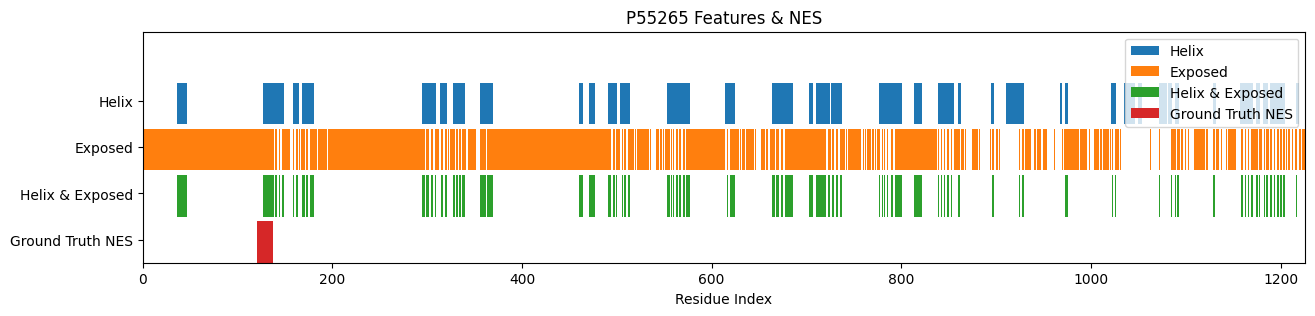

In [24]:
# STEP 1 (optional): Plot Feature Block for one protein Example
pdb_path = "data/AF-P55265-F1-model_v4.pdb" # AF-P55265-F1-model_v4.pdb or AF-O00311-F1-model_v4.pdb
is_helix, is_exposed = parse_dssp(pdb_path, rsa_thresh=0.2)

# print("Helix:", is_helix)
# print("Exposed:", is_exposed)

total = len(is_exposed)
num_exposed = sum(is_exposed)
percent_exposed = 100 * num_exposed / total if total > 0 else 0
num_helix = sum(is_helix)
percent_helix = 100 * num_helix / total if total > 0 else 0
num_helix_exposed = sum(h and e for h, e in zip(is_helix, is_exposed))
percent_helix_exposed = 100 * num_helix_exposed / total if total > 0 else 0

print(f"Total residues: {total}")
print(f"Exposed residues: {num_exposed} ({percent_exposed:.2f}%)")
print(f"Helix residues: {num_helix} ({percent_helix:.2f}%)")
print(f"Helix & Exposed residues: {num_helix_exposed} ({percent_helix_exposed:.2f}%)")

csv_path = "../../segmentation/NESDB_combined_database_unique_rows.csv"
uniprot_id = "P55265"

ground_truth_ranges = get_ground_truth_ranges(csv_path, uniprot_id)
plot_feature_blocks(is_helix, is_exposed, ground_truth_ranges, title="P55265 Features & NES")

In [54]:
# STEP 2: Download AlphaFold Models
uniprot_ids = get_uniprot_ids_from_csv(csv_path)

print(f"Found {len(uniprot_ids)} UniProt IDs")
results = download_alphafold_pdbs(uniprot_ids)

# Summary
success_count = sum(results.values())
print(f"\n✅ Download summary: {success_count}/{len(uniprot_ids)} successful")

Found 168 UniProt IDs
✅ Successfully downloaded O95149
❌ Failed to download P69718: HTTP status 404
✅ Successfully downloaded Q96D46
✅ Successfully downloaded P38861
✅ Successfully downloaded P61925
✅ Successfully downloaded P04637
✅ Successfully downloaded P43487
✅ Successfully downloaded P13350
✅ Successfully downloaded P38398
✅ Successfully downloaded Q05116
✅ Successfully downloaded P14635
✅ Successfully downloaded Q00987
✅ Successfully downloaded Q13485
✅ Successfully downloaded O60716
✅ Successfully downloaded P49138
✅ Successfully downloaded Q06787
✅ Successfully downloaded Q04584
✅ Successfully downloaded Q04206
✅ Successfully downloaded P42224
✅ Successfully downloaded Q14872
✅ Successfully downloaded P11484
✅ Successfully downloaded O35973
✅ Successfully downloaded O54943
✅ Successfully downloaded Q9Y572
✅ Successfully downloaded P10688
❌ Failed to download P03243: HTTP status 404
✅ Successfully downloaded P47973
✅ Successfully downloaded P25963
✅ Successfully downloaded Q146

In [29]:
# STEP 3: NES Region Evaluation and Control Benchmarking

csv_path = "../../segmentation/NESDB_combined_database_unique_rows.csv"
pdb_folder = "data/alphafold_pdbs"
pdb_files = sorted(glob.glob(f"{pdb_folder}/*.pdb"))  # P55265.pdb, etc.

results = []

for pdb_path in pdb_files:
    result = evaluate_protein(pdb_path, csv_path)
    if result:
        results.append(result)

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("data/full_AF_NES_exposure_summary.csv", index=False)

# Print summary
print("✅ Evaluation complete.")


✅ Evaluation complete.


In [30]:
# STEP 4: Data Analysis

#Compare percentages in NES vs control.
#Compare absolute counts (average number of residues) that are: Exposed, Helical, Both 
#in both NES and control.

data_analysis(df)

=== AVERAGE % METRICS ===
Avg % exposed in NES:     75.22%
Avg % exposed in Control: 72.20%

Avg % helix in NES:       56.65%
Avg % helix in Control:   30.12%

Avg % helix+exposed in NES:     40.69%
Avg % helix+exposed in Control: 18.20%

=== AVERAGE ABSOLUTE COUNTS ===
Avg # exposed in NES:     15.48
Avg # exposed in Control: 18.95

Avg # helix in NES:       12.25
Avg # helix in Control:   8.68

Avg # helix+exposed in NES:     8.32
Avg # helix+exposed in Control: 5.07


=== Paired t-tests (NES vs Control) ===
Exposed: t=1.15, p=0.2522
Helix:   t=8.45, p=0.0000
Both:    t=8.64, p=0.0000


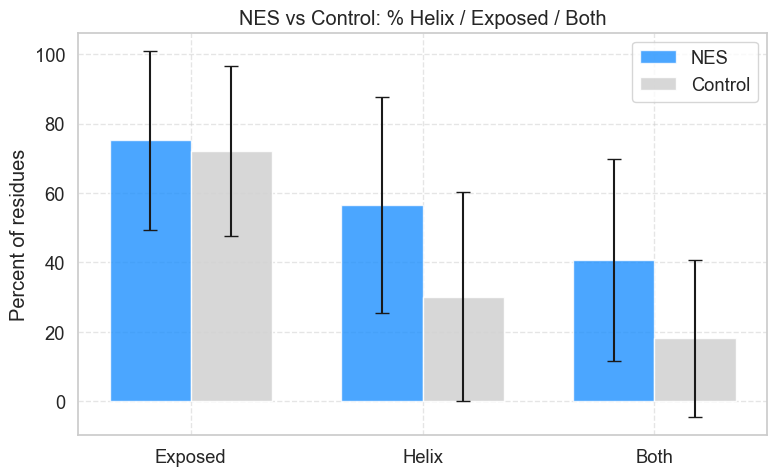

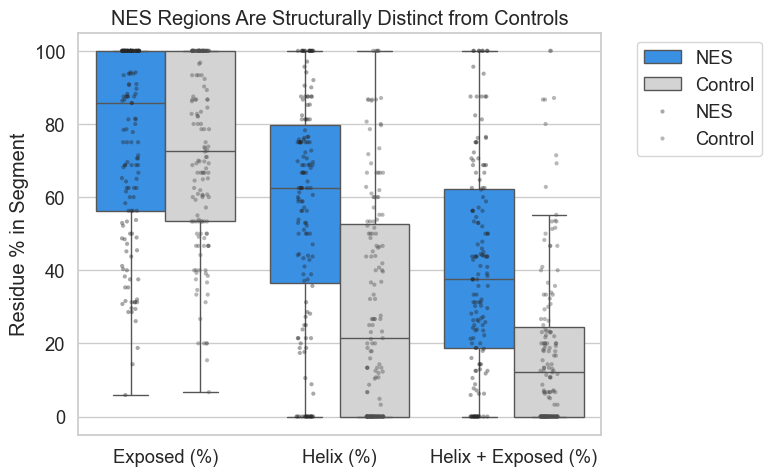

In [41]:
#STEP 5: Statistical Comparison of NES and Control Segments
analyze_and_plot_nes_vs_control(df)

In [38]:
#  STEP 6: Export Per-Residue Annotation Table (Binary Vectors)
# This generates a CSV where each protein has binary strings like:
# exposed: 0001110001
# helix: 0010110000
# both: 0000110000
#Can be used for training classifiers or other machine learning approaches.

from glob import glob

annotation_rows = []

for pdb_path in pdb_files:
    row = residue_annotation_row(pdb_path, csv_path)
    if row:
        annotation_rows.append(row)

# Create and save DataFrame
df_for_noam = pd.DataFrame(annotation_rows)
df_for_noam.to_csv("data/residue_annotations.csv", index=False)
print("✅ Saved residue_annotations.csv")


✅ Saved residue_annotations.csv
